# MNIST experiments

> Experiments on MNIST dataset with Feedforward, FFF and convolutional networks

In [ ]:
#|default_exp activations

In [ ]:
#|export
import math, torch, matplotlib as mpl, matplotlib.pyplot as plt
from torch import nn
import matplotlib.colors as mcolors
from fastai.vision.all import *
from FastFF import fff, ultrafastbert

In [ ]:
#|hide
import math
import torch
import torchvision.transforms as T
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from fastai.vision.all import *
from torchvision.datasets import MNIST

Hyper-parameters

In [ ]:
#|hide
set_seed(0)
n_cores = num_cpus()

In [ ]:
bs = 256 # batch size
h = 256 # number of hidden neurons

First load the MNIST dataset

In [ ]:
mean, std = 0.130652368068695068, 0.307504087686538696

tfm = T.Compose([T.ToTensor(),T.Normalize((mean,), (std,))])

train_dataset = MNIST('../data', train=True, download=True,transform=tfm)
test_dataset = MNIST('../data', train=False, download=True,transform=tfm)

In [ ]:
dls = DataLoaders(TfmdDL(train_dataset, bs, True, n_cores),TfmdDL(test_dataset, bs, False, n_cores))

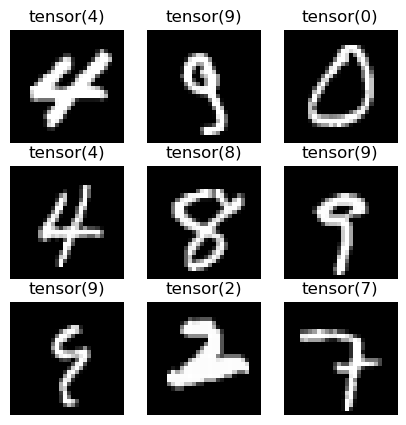

In [ ]:
show_image_batch(dls.one_batch(), cmap='gray', figsize=(5,5))

In [ ]:
dls.one_batch()[0].shape

torch.Size([256, 1, 28, 28])

# Baseline
Baseline model with single hidden layer with `h` hidden neurons

In [ ]:
model_ff = nn.Sequential(
    nn.Linear(28*28, h),
    nn.PReLU(),
    nn.Linear(h, 2), # learn 2d projection
    nn.PReLU(),
    nn.Linear(2, 10)
)

Add callback that flattens 28x28 images into vectors of size 784 

In [ ]:
@before_batch_cb
def flatten_cb(self, xb, yb): 
    return (xb[0].view(-1,28*28),),yb

In [ ]:
cbs = [flatten_cb, ShowGraphCallback()]
learn = Learner(dls, model_ff, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.951607,0.709811,0.815300,00:16
1,0.469968,0.455491,0.897800,00:12
2,0.366506,0.413589,0.905200,00:11
3,0.305947,0.351673,0.926100,00:11
4,0.282366,0.331769,0.920500,00:11
5,0.242505,0.288509,0.939600,00:11
6,0.185478,0.277068,0.947200,00:11
7,0.159101,0.291077,0.944600,00:11
8,0.129956,0.255356,0.952700,00:11
9,0.092949,0.274778,0.954700,00:11


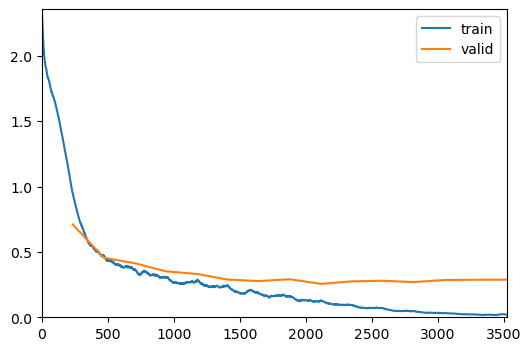

In [ ]:
#|eval: false
learn.fit_one_cycle(15, lr_max=2e-2)

In [ ]:
#|export
class Activations2D(HookCallback):
    def __init__(self, module = None, **kwargs):
        super().__init__([module], **kwargs)
        
    def before_fit(self):
        super().before_fit()
        self.activations, self.targets = [], []
    
    def hook(self, m, i, o): return o
    
    def after_batch(self):
        '''Store activations and targets for batch'''
        self.activations.append(self.hooks.stored[0])
        self.targets.append(self.yb[0])
        
    def after_fit(self):
        self.activations, self.targets = torch.cat(self.activations), torch.cat(self.targets)
        super().after_fit()
    
    def show_acts(self, prj_idxs=(0,1), ax=None, figsize=(10,5), alpha=0.6, s=5, cmap='tab10', **kwargs):
        if ax is None: _, ax = plt.subplots(figsize=figsize)
        u = self.targets.unique()
        norm = mpl.colors.Normalize(vmin=0, vmax=len(u)-1)
        if not isinstance(cmap,mcolors.Colormap): cmap = plt.get_cmap(cmap)
        colors = cmap(norm(range(len(u))))
        for col, l in zip(colors,u):
            xs = self.activations[self.targets==l]
            ax.scatter(xs[:,prj_idxs[0]], xs[:,prj_idxs[1]], alpha=alpha, color=col, label=l.item(), s=s, **kwargs)
        ax.set_title('2D activations')
        ax.legend()

In [ ]:
#|eval: false
act = Activations2D(model_ff[-3])
learn.get_preds(dl = dls.train, cbs=act);

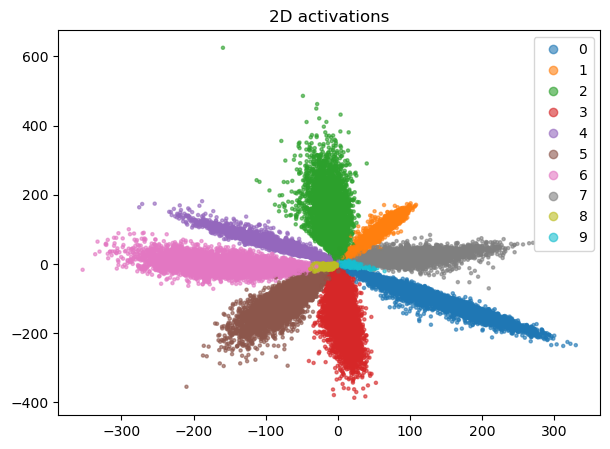

In [ ]:
#|eval: false
act.show_acts(figsize=(7,5))

# Fast Feed-forward network

Feed-forward layer, Mixture-of-experts layer and Fast Feed-forward layer.

FFF forms a tree that splits space into regions

<img width="700" src="images/ff_moe_fff.png" id="jupyter"/>

### First implementation from https://github.com/pbelcak/fastfeedforward/blob/main/fastfeedforward/fff.py

In [ ]:
n_leaves = 16
d = int(math.log2(n_leaves))
ls = h//n_leaves
model_fff = nn.Sequential(fff.FFF(28*28, 32, 2, d), nn.PReLU(), nn.Linear(2, 10))

Comparison for number of parameters

In [ ]:
#|export
def num_params(model): return sum(p.numel() for p in model.parameters())

In [ ]:
num_params(model_fff), num_params(model_ff)

(414783, 201506)

In [ ]:
cbs = [ShowGraphCallback(), flatten_cb]
learn = Learner(dls, model_fff, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)

epoch,train_loss,valid_loss,accuracy,time
0,0.834164,1.123676,0.761100,00:15
1,0.556161,0.748175,0.859200,00:13
2,0.473483,0.552138,0.884500,00:14
3,0.434961,0.522497,0.893800,00:22
4,0.376043,0.439266,0.910600,00:18
5,0.325437,0.441021,0.910900,00:15
6,0.282564,0.402824,0.927100,00:16
7,0.246223,0.391051,0.934100,00:18
8,0.214984,0.366360,0.933900,00:17
9,0.166806,0.335646,0.944800,00:15


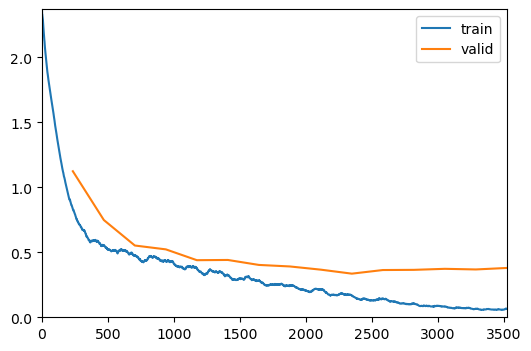

In [ ]:
#|eval: false
learn.fit_one_cycle(15, lr_max=2e-2)

### Leaves coloring

In [ ]:
#|export
class LeavesColors(Activations2D):
    '''Gets points from `module` output and colors from `fff_module` corresponding to leaves'''
    def __init__(self, module = None, fff_module = None, **kwargs):
        assert isinstance(fff_module,fff.FFF)
        self.fff_module = fff_module
        super().__init__(module, **kwargs)
    def after_batch(self):
        '''Store activations and targets for batch'''
        self.activations.append(self.hooks.stored[0])
        self.targets.append(self.fff_module.leaves)

In [ ]:
#|eval: false
acts = [Activations2D(model_fff[-2]), LeavesColors(model_fff[-2],model_fff[0])]
learn.get_preds(dl = dls.train, cbs=acts);

We see that every data point ends up in one of 10 leaves, which is exactly the same number as number of classes

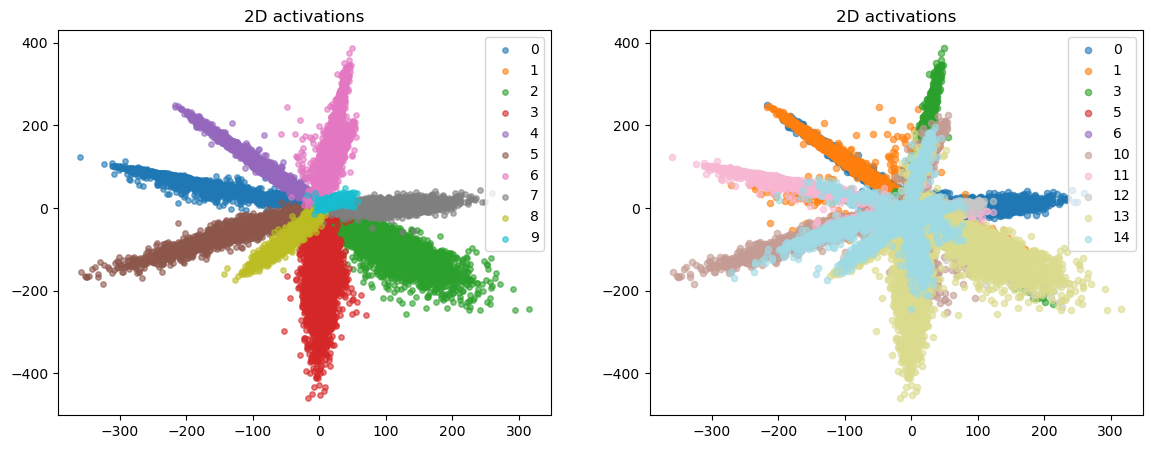

In [ ]:
#|eval: false
axes = subplots(ncols=2,figsize=(14,5))[1]
acts[0].show_acts(ax=axes[0], cmap='tab10',s=15)
acts[1].show_acts(ax=axes[1], cmap='tab20',s=20)

### Example with untrained model

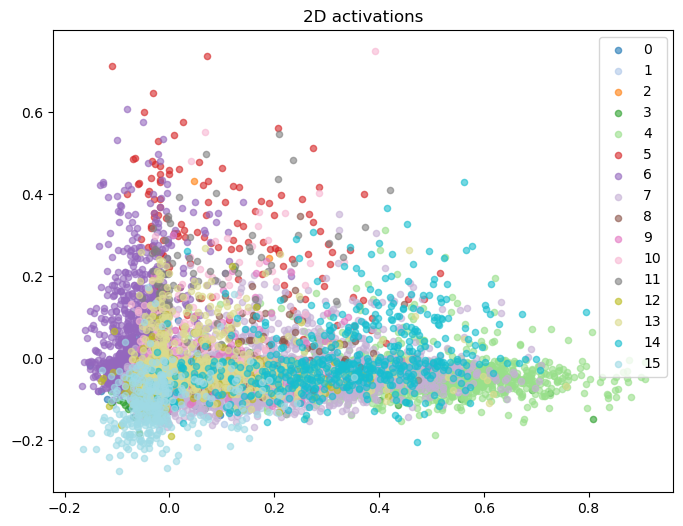

In [ ]:
#|eval: false
model_fff = nn.Sequential(fff.FFF(28*28, 64, 2, 4), nn.PReLU(), nn.Linear(2, 10))

act = LeavesColors(model_fff[-2],model_fff[0])
Learner(dls, model_fff, loss_func=F.cross_entropy, cbs=cbs+[act]).get_preds(dl = dls.valid)
act.show_acts(figsize=(8,6), cmap='tab20',s=20)

### Second implentation is from UltraFastBERT repository. 

from https://github.com/pbelcak/UltraFastBERT/blob/main/training/cramming/architectures/fff.py <br>
This tree doesn't have sigmoids and leaves

In [ ]:
n_trees = 8                     # number of trees
d = int(math.log2(h/n_trees)-1) # depth of the tree
model_fff2 = nn.Sequential(ultrafastbert.FFF(28*28, 2, d, n_trees), nn.PReLU(), nn.Linear(2, 10))

In [ ]:
num_params(model_fff2), num_params(model_ff)

(195208, 201506)

epoch,train_loss,valid_loss,accuracy,time
0,1.041744,0.867091,0.729900,00:13
1,0.586542,0.561119,0.871500,00:11
2,0.471197,0.510785,0.877800,00:13
3,0.429812,0.442934,0.898400,00:17
4,0.383739,0.451936,0.890900,00:14
5,0.355250,0.396733,0.916200,00:11
6,0.326995,0.447875,0.897900,00:11
7,0.289385,0.362277,0.927100,00:11
8,0.257353,0.327394,0.937000,00:11
9,0.241924,0.333332,0.934700,00:11


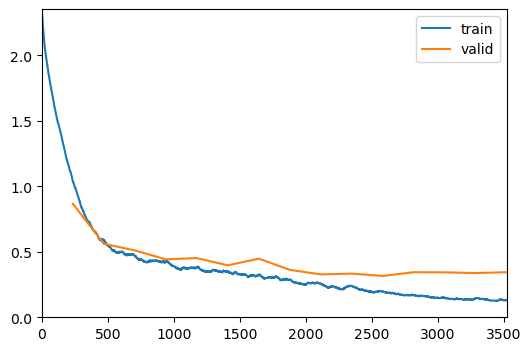

In [ ]:
#|eval: false
cbs = [ShowGraphCallback(), flatten_cb]
learn = Learner(dls, model_fff2, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)
learn.fit_one_cycle(15, lr_max=2e-2)

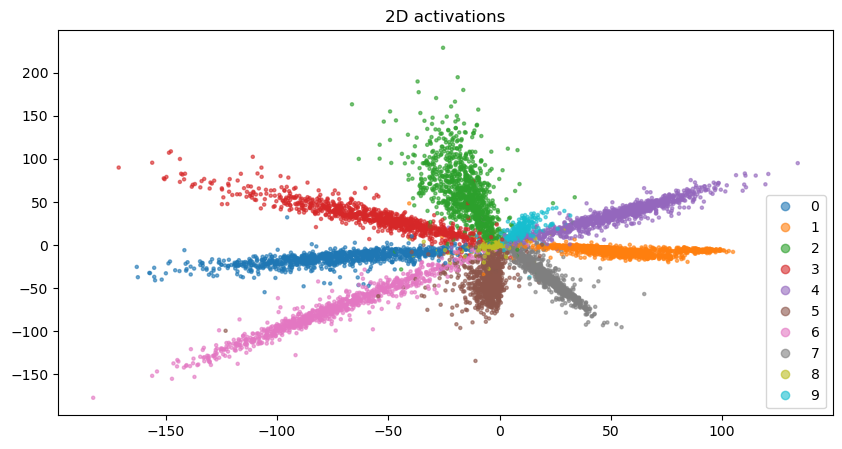

In [ ]:
#|eval: false
act = Activations2D(model_fff2[-3])
learn.get_preds(dl = dls.train, cbs=act)
act.show_acts(figsize=(10,5), cmap='tab10')

# Convolutional network

In [ ]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.PReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [ ]:
model_cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    nn.Flatten(),
    nn.Linear(64,256),
    nn.PReLU(),
    nn.Linear(256, 2),      # 2d projection
    nn.PReLU(),
    nn.Linear(2, 10)
)

epoch,train_loss,valid_loss,accuracy,time
0,1.529176,1.287408,0.512300,00:20
1,0.566232,0.437286,0.911100,00:22
2,0.359668,0.310705,0.935600,00:19
3,0.290927,0.290132,0.933700,00:22
4,0.251578,0.232164,0.948900,00:20
5,0.205830,0.232239,0.944900,00:22
6,0.188679,0.197948,0.962300,00:23
7,0.167010,0.205799,0.959600,00:20
8,0.138813,0.168045,0.964100,00:19
9,0.114244,0.155966,0.969400,00:21


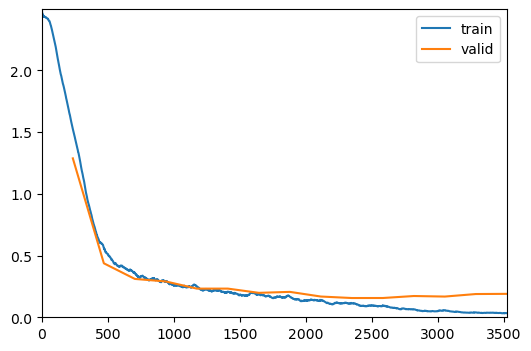

In [ ]:
#|eval: false
cbs = [ShowGraphCallback()]
learn = Learner(dls, model_cnn, loss_func=F.cross_entropy, metrics=accuracy, opt_func = Adam, cbs=cbs)
learn.fit_one_cycle(15, lr_max=1e-2)

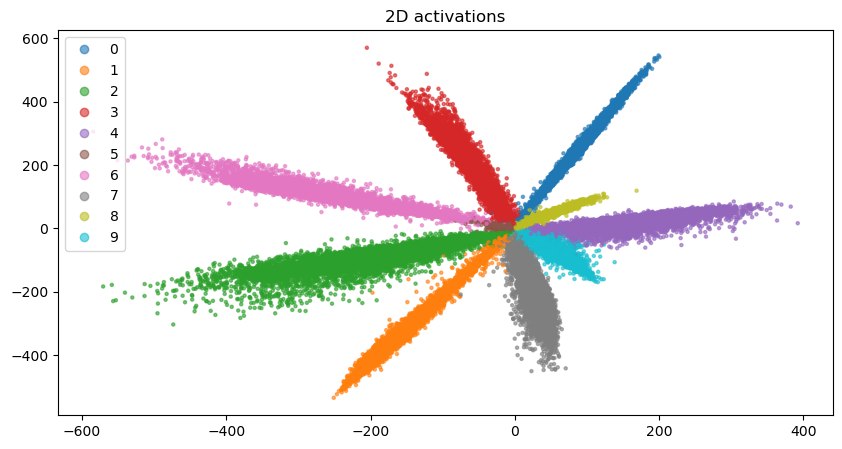

In [ ]:
#|eval: false
act = Activations2D(model_cnn[-3])
learn.get_preds(dl = dls.train, cbs=act);
act.show_acts(figsize=(10,5))

In [ ]:
# | hide
import nbdev; nbdev.nbdev_export()